# Pointwise Classification

In this notebook, we examine the pointwise classification approach, including tuning and trying different estimators. First, we load the required dependencies and the data.

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
from category_encoders.binary import BinaryEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from datetime import timedelta
from sklearn.compose import ColumnTransformer
from time import time

from src import configuration as config
from src.pipeline.pipeline_factory import PipelineFactory, ModelType, EvaluationType
from src.pipeline.pipeline_transformers import *


# load the data
train_df = config.load_traindata_for_pointwise()
pipelineFactory = PipelineFactory()

In [10]:
# group by the columns: model, tuning, scoring
# for each group print out the unique values of the rank column
grouped_df = train_df.groupby(["model", "tuning", "scoring"])["rank"].value_counts()
print(grouped_df)
# save the grouped dataframe to a csv file
path = os.path.join(config.FIGURE_DIR, "pointwise_ranking.csv")
grouped_df.to_csv(path)

model  tuning  scoring  rank
DTC    full    ACC      0.0     135
                        1.0      71
                        2.0      50
                        3.0      43
                        5.0      39
                               ... 
SVC    no      F1       27.0      9
                        28.0      7
                        29.0      6
                        30.0      5
                        31.0      2
Name: count, Length: 1146, dtype: int64


## Pointwise Classification

In [2]:
start = time()

# running the pipeline plain wihout parameter tuning using cross validation
pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.POINTWISE_CLASSIFICATION_NO_SEARCH,
    evaluation=EvaluationType.CROSS_VALIDATION,
    verbose_level=1,
    n_folds=5,
    workers=16,
    target="rank"
)

#pipeline.add_new_step(PrintDataframe(verbose=1), "print_dataframe_1")
print(pipeline.get_pipeline().named_steps)
pipeline.run()

runtime = int(time() - start)
print('\nruntime: ' + str(timedelta(seconds=runtime)) + ' [' + str(runtime) + 's]')

Creating pipeline ...
{'keeper': ColumnKeeper(columns=['dataset', 'model', 'tuning', 'scoring', 'encoder']), 'encoder_transformer': PoincareEmbedding(batch_size=50, encoder=OneHotEncoder(), epochs=500,
                  graph=<networkx.classes.graph.Graph object at 0x7fa48db03be0>,
                  size=3), 'dataset_transformer': OpenMLMetaFeatureTransformer(encoder=None, expected_pca_variance=0.6,
                             nan_ratio_feature_drop_threshold=0.25), 'general_transformer': GeneralPurposeEncoderTransformer(model_encoder=OneHotEncoder(),
                                 scoring_encoder=TargetEncoder(),
                                 tuning_encoder=TargetEncoder()), 'estimator': DecisionTreeClassifier()}
Starting pipeline using method: EvaluationType.CROSS_VALIDATION


100%|█████████████████████████████████████████████| 5/5 [01:02<00:00, 12.41s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.7575
    validation_average_spearman_fold_1: 0.7082
    validation_average_spearman_fold_2: 0.7
    validation_average_spearman_fold_3: 0.7583
    validation_average_spearman_fold_4: 0.7527
    average of all folds: 0.7353 [std=0.0257]

runtime: 0:01:14 [74s]


We get a very good score of > 0.7. Let's try to optimize the score

In [12]:
param_grid = {
    "encoder_transformer__batch_size": [50, 500],
    "general_transformer__model_encoder" : [BinaryEncoder(), OneHotEncoder(), OrdinalEncoder(), TargetEncoder()],
    "general_transformer__tuning_encoder" : [BinaryEncoder(), OneHotEncoder(), OrdinalEncoder(), TargetEncoder()],
    "general_transformer__scoring_encoder" : [BinaryEncoder(), OneHotEncoder(), OrdinalEncoder(), TargetEncoder()],
}

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.POINTWISE_CLASSIFICATION_NO_SEARCH,
    verbose_level=1,
    evaluation=EvaluationType.GRID_SEARCH,
    param_grid=param_grid,
    n_folds=2,
    workers=1,
    target="rank"
)

pipeline.run()

Creating pipeline ...
Starting pipeline using method: EvaluationType.GRID_SEARCH
Performing grid search


100%|██████████| 128/128 [25:14<00:00, 11.83s/it]

Finished running the pipeline
Evaluation metrics:
    best_score: 0.7573
    best_params: {'encoder_transformer__batch_size': 500, 'general_transformer__model_encoder': OrdinalEncoder(cols=['model'],
               mapping=[{'col': 'model', 'data_type': dtype('O'),
                         'mapping': LR       1
SVC      2
LGBMC    3
DTC      4
KNC      5
NaN     -2
dtype: int64}]), 'general_transformer__tuning_encoder': OrdinalEncoder(cols=['tuning'],
               mapping=[{'col': 'tuning', 'data_type': dtype('O'),
                         'mapping': model    1
no       2
full     3
NaN     -2
dtype: int64}]), 'general_transformer__scoring_encoder': OrdinalEncoder(cols=['scoring'],
               mapping=[{'col': 'scoring', 'data_type': dtype('O'),
                         'mapping': ACC    1
AUC    2
F1     3
NaN   -2
dtype: int64}])}


The best parameters for this run are:  
batch_size: 500  
model_encoder: OrdinalEncoder  
tuning_encoder: OrdinalEncoder  
scoring_encoder: OrdinalEncoder

In [5]:
param_grid = {
    "encoder_transformer__batch_size": [700, 800, 900],
    "general_transformer__model_encoder" : [OrdinalEncoder()],
    "general_transformer__tuning_encoder" : [OrdinalEncoder()],
    "general_transformer__scoring_encoder" : [OrdinalEncoder()],
}

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.POINTWISE_CLASSIFICATION_NO_SEARCH,
    verbose_level=1,
    evaluation=EvaluationType.GRID_SEARCH,
    param_grid=param_grid,
    n_folds=2,
    workers=1,
    target="rank"
)
print(pipeline.get_pipeline().named_steps)
pipeline.run()

Creating pipeline ...
{'keeper': ColumnKeeper(columns=['dataset', 'model', 'tuning', 'scoring', 'encoder']), 'encoder_transformer': PoincareEmbedding(batch_size=50, encoder=OneHotEncoder(), epochs=500,
                  graph=<networkx.classes.graph.Graph object at 0x000001D37C8C6710>,
                  size=3), 'dataset_transformer': OpenMLMetaFeatureTransformer(encoder=None, expected_pca_variance=0.6,
                             nan_ratio_feature_drop_threshold=0.25), 'general_transformer': GeneralPurposeEncoderTransformer(model_encoder=OneHotEncoder(),
                                 scoring_encoder=TargetEncoder(),
                                 tuning_encoder=TargetEncoder()), 'estimator': DecisionTreeClassifier()}
Starting pipeline using method: EvaluationType.GRID_SEARCH
Performing grid search


  0%|          | 0/3 [00:00<?, ?it/s]100%|██████████| 3/3 [01:14<00:00, 24.70s/it]

Finished running the pipeline
Evaluation metrics:
    best_score: 0.7578
    best_params: {'encoder_transformer__batch_size': 700, 'general_transformer__model_encoder': OrdinalEncoder(cols=['model'],
               mapping=[{'col': 'model', 'data_type': dtype('O'),
                         'mapping': LR       1
SVC      2
LGBMC    3
DTC      4
KNC      5
NaN     -2
dtype: int64}]), 'general_transformer__tuning_encoder': OrdinalEncoder(cols=['tuning'],
               mapping=[{'col': 'tuning', 'data_type': dtype('O'),
                         'mapping': model    1
no       2
full     3
NaN     -2
dtype: int64}]), 'general_transformer__scoring_encoder': OrdinalEncoder(cols=['scoring'],
               mapping=[{'col': 'scoring', 'data_type': dtype('O'),
                         'mapping': ACC    1
AUC    2
F1     3
NaN   -2
dtype: int64}])}


In [18]:
param_grid = {
    "encoder_transformer__batch_size": [700, 800, 900],
    "general_transformer__model_encoder" : [OrdinalEncoder()],
    "general_transformer__tuning_encoder" : [OrdinalEncoder()],
    "general_transformer__scoring_encoder" : [OrdinalEncoder()],
    "estimator__criterion": ["gini", "entropy"],
    "estimator__splitter": ["best", "random"],
    "estimator__max_depth": [None],
    "estimator__min_samples_split": [3, 20, 40],
    "estimator__min_samples_leaf": [1, 10, 20],
    "estimator__min_weight_fraction_leaf": [0.0, 0.1, 0.2],
    "estimator__class_weight": [None, "balanced"],
}

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.POINTWISE_CLASSIFICATION_NO_SEARCH,
    verbose_level=1,
    evaluation=EvaluationType.GRID_SEARCH,
    param_grid=param_grid,
    n_folds=2,
    workers=1,
    target="rank"
)

pipeline.run()

Creating pipeline ...
Starting pipeline using method: EvaluationType.GRID_SEARCH
Performing grid search


  1%|          | 4/648 [00:46<2:04:48, 11.63s/it]c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
  2%|▏         | 10/648 [01:56<2:03:21, 11.60s/it]c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
  2%|▏         | 16/648 [03:06<2:02:19, 11.61s/it]c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
  3%|▎         | 22/648 [04:15<2:01:02, 11.60s/it]c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
  4%|▍         | 28/648 [05:25<2:00:07, 11.62s/it]c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf

Finished running the pipeline
Evaluation metrics:
    best_score: 0.7461
    best_params: {'encoder_transformer__batch_size': 800, 'general_transformer__model_encoder': OrdinalEncoder(cols=['model'],
               mapping=[{'col': 'model', 'data_type': dtype('O'),
                         'mapping': LR       1
SVC      2
LGBMC    3
DTC      4
KNC      5
NaN     -2
dtype: int64}]), 'general_transformer__tuning_encoder': OrdinalEncoder(cols=['tuning'],
               mapping=[{'col': 'tuning', 'data_type': dtype('O'),
                         'mapping': model    1
no       2
full     3
NaN     -2
dtype: int64}]), 'general_transformer__scoring_encoder': OrdinalEncoder(cols=['scoring'],
               mapping=[{'col': 'scoring', 'data_type': dtype('O'),
                         'mapping': ACC    1
AUC    2
F1     3
NaN   -2
dtype: int64}]), 'estimator__criterion': 'entropy', 'estimator__splitter': 'best', 'estimator__max_depth': None, 'estimator__min_samples_split': 3, 'estimator__min_sam

running the grid search took 127 minutes  
The best performing parameters are:  
'encoder_transformer__batch_size': 800  
'estimator__criterion': 'entropy'  
'estimator__splitter': 'best'  
'estimator__max_depth': None  
'estimator__min_samples_split': 3  
'estimator__min_samples_leaf': 1  
'estimator__min_weight_fraction_leaf': 0.0  
'estimator__class_weight': None  

In [19]:
param_grid = {
    "encoder_transformer__batch_size": [800],
    "general_transformer__model_encoder" : [OrdinalEncoder()],
    "general_transformer__tuning_encoder" : [OrdinalEncoder()],
    "general_transformer__scoring_encoder" : [OrdinalEncoder()],
    "estimator__criterion": ["gini", "entropy"],
    "estimator__splitter": ["best"],
    "estimator__max_depth": [None],
    "estimator__min_samples_split": [2, 3],
    "estimator__min_samples_leaf": [1],
    "estimator__min_weight_fraction_leaf": [0.0, 0.5],
    "estimator__class_weight": [None],
}

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.POINTWISE_CLASSIFICATION_NO_SEARCH,
    verbose_level=1,
    evaluation=EvaluationType.GRID_SEARCH,
    param_grid=param_grid,
    n_folds=2,
    workers=1,
    target="rank"
)

pipeline.run()

Creating pipeline ...
Starting pipeline using method: EvaluationType.GRID_SEARCH
Performing grid search


 12%|█▎        | 1/8 [00:11<01:22, 11.84s/it]c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
 38%|███▊      | 3/8 [00:35<00:58, 11.72s/it]c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
 62%|██████▎   | 5/8 [00:58<00:35, 11.74s/it]c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  re

Finished running the pipeline
Evaluation metrics:
    best_score: 0.7614
    best_params: {'encoder_transformer__batch_size': 800, 'general_transformer__model_encoder': OrdinalEncoder(cols=['model'],
               mapping=[{'col': 'model', 'data_type': dtype('O'),
                         'mapping': LR       1
SVC      2
LGBMC    3
DTC      4
KNC      5
NaN     -2
dtype: int64}]), 'general_transformer__tuning_encoder': OrdinalEncoder(cols=['tuning'],
               mapping=[{'col': 'tuning', 'data_type': dtype('O'),
                         'mapping': model    1
no       2
full     3
NaN     -2
dtype: int64}]), 'general_transformer__scoring_encoder': OrdinalEncoder(cols=['scoring'],
               mapping=[{'col': 'scoring', 'data_type': dtype('O'),
                         'mapping': ACC    1
AUC    2
F1     3
NaN   -2
dtype: int64}]), 'estimator__criterion': 'entropy', 'estimator__splitter': 'best', 'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__min_sam

In [2]:
param_grid = {
    "encoder_transformer__batch_size": [800],
    "general_transformer__model_encoder" : [OrdinalEncoder()],
    "general_transformer__tuning_encoder" : [OrdinalEncoder()],
    "general_transformer__scoring_encoder" : [OrdinalEncoder()],
    "estimator__criterion": ["entropy"],
    "estimator__splitter": ["best"],
    "estimator__max_depth": [None],
    "estimator__min_samples_split": [2],
    "estimator__min_samples_leaf": [1],
    "estimator__min_weight_fraction_leaf": [0.0],
    "estimator__class_weight": [None],
}

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.POINTWISE_CLASSIFICATION_NO_SEARCH,
    verbose_level=1,
    evaluation=EvaluationType.GRID_SEARCH,
    param_grid=param_grid,
    n_folds=2,
    workers=1,
    target="rank"
)

pipeline.run()

Creating pipeline ...
Starting pipeline using method: EvaluationType.GRID_SEARCH
Performing grid search


100%|██████████| 1/1 [00:27<00:00, 27.87s/it]

Finished running the pipeline
Evaluation metrics:
    best_score: 0.7681
    best_params: {'encoder_transformer__batch_size': 800, 'general_transformer__model_encoder': OrdinalEncoder(cols=['model'],
               mapping=[{'col': 'model', 'data_type': dtype('O'),
                         'mapping': LR       1
SVC      2
LGBMC    3
DTC      4
KNC      5
NaN     -2
dtype: int64}]), 'general_transformer__tuning_encoder': OrdinalEncoder(cols=['tuning'],
               mapping=[{'col': 'tuning', 'data_type': dtype('O'),
                         'mapping': model    1
no       2
full     3
NaN     -2
dtype: int64}]), 'general_transformer__scoring_encoder': OrdinalEncoder(cols=['scoring'],
               mapping=[{'col': 'scoring', 'data_type': dtype('O'),
                         'mapping': ACC    1
AUC    2
F1     3
NaN   -2
dtype: int64}]), 'estimator__criterion': 'entropy', 'estimator__splitter': 'best', 'estimator__max_depth': None, 'estimator__min_samples_split': 2, 'estimator__min_sam

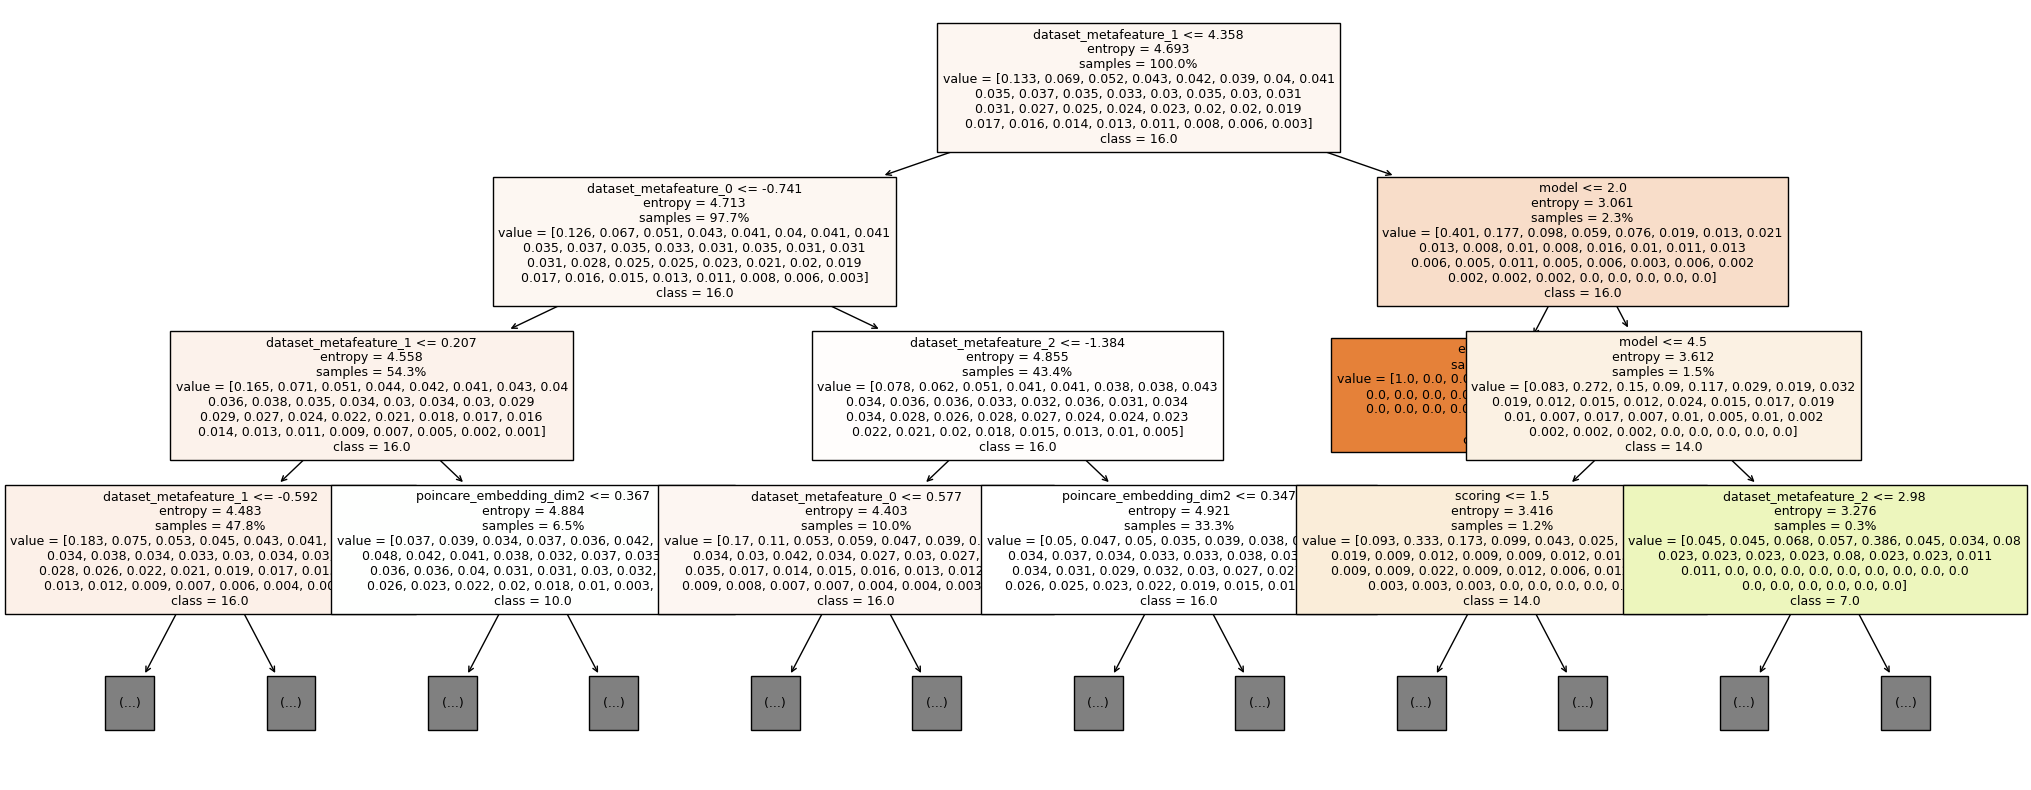

In [17]:
from matplotlib import pyplot as plt
from sklearn import tree

# assuming that you have already trained a decision tree classifier and stored it in the variable 'clf'
clf = pipeline.get_pipeline().named_steps['estimator']

# loop over every step but estimator
X = train_df.drop(columns=['rank'])
for step in pipeline.get_pipeline().steps[:-1]:
    X = step[1].transform(X)

y = train_df['rank'].unique().astype('str') # convert unique values to a list of strings

fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns.tolist(),  
                   class_names=y,
                   filled=True,
                   max_depth=3,
                   fontsize=9,
                   proportion=True,)

# save path
path = os.path.join(config.FIGURE_DIR, 'decision_tree.svg')
fig.savefig(path, format="svg")

#### Trying out Adaboost

In [21]:
param_grid = {
    "encoder_transformer__batch_size": [800],
    "general_transformer__model_encoder" : [OrdinalEncoder()],
    "general_transformer__tuning_encoder" : [OrdinalEncoder()],
    "general_transformer__scoring_encoder" : [OrdinalEncoder()],
    "estimator__n_estimators": [1, 5, 50],
    "estimator__learning_rate": [0.1, 0.5, 1.0],
    "estimator__algorithm": ["SAMME", "SAMME.R"],
}

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.POINTWISE_CLASSIFICATION_NO_SEARCH,
    verbose_level=1,
    evaluation=EvaluationType.GRID_SEARCH,
    param_grid=param_grid,
    n_folds=2,
    workers=1,
    target="rank"
)

# trying out boosted decision trees
from sklearn.ensemble import AdaBoostClassifier

pipeline.change_estimator(AdaBoostClassifier())

pipeline.run()

Creating pipeline ...
Starting pipeline using method: EvaluationType.GRID_SEARCH
Performing grid search


  0%|          | 0/18 [00:00<?, ?it/s]c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
  6%|▌         | 1/18 [00:11<03:17, 11.63s/it]c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
 11%|█         | 2/18 [00:23<03:07, 11.70s/it]c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return np.nanmean(list_spearman(rf1, rf2))
c:\workspace\phase-2\src\pipeline\evaluation\evaluation_utils.py:218: RuntimeWarning: Mean of empty slice
  return 

Finished running the pipeline
Evaluation metrics:
    best_score: 0.1499
    best_params: {'encoder_transformer__batch_size': 800, 'general_transformer__model_encoder': OrdinalEncoder(cols=['model'],
               mapping=[{'col': 'model', 'data_type': dtype('O'),
                         'mapping': LR       1
SVC      2
LGBMC    3
DTC      4
KNC      5
NaN     -2
dtype: int64}]), 'general_transformer__tuning_encoder': OrdinalEncoder(cols=['tuning'],
               mapping=[{'col': 'tuning', 'data_type': dtype('O'),
                         'mapping': model    1
no       2
full     3
NaN     -2
dtype: int64}]), 'general_transformer__scoring_encoder': OrdinalEncoder(cols=['scoring'],
               mapping=[{'col': 'scoring', 'data_type': dtype('O'),
                         'mapping': ACC    1
AUC    2
F1     3
NaN   -2
dtype: int64}]), 'estimator__n_estimators': 50, 'estimator__learning_rate': 1.0, 'estimator__algorithm': 'SAMME.R'}


The best score is considerably lower than the one we got with the plain decision tree.

#### Trying out Random Forest (Bagging)

In [25]:
param_grid = {
    "encoder_transformer__batch_size": [800],
    "general_transformer__model_encoder" : [OrdinalEncoder()],
    "general_transformer__tuning_encoder" : [OrdinalEncoder()],
    "general_transformer__scoring_encoder" : [OrdinalEncoder()],
    "estimator__n_estimators": [200, 500, 1000],
    "estimator__criterion": ["gini", "entropy"],
}

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.POINTWISE_CLASSIFICATION_NO_SEARCH,
    verbose_level=1,
    evaluation=EvaluationType.GRID_SEARCH,
    param_grid=param_grid,
    n_folds=2,
    workers=1,
    target="rank"
)

# trying out bagged decision trees
from sklearn.ensemble import RandomForestClassifier

pipeline.change_estimator(RandomForestClassifier())

pipeline.run()

Creating pipeline ...
Starting pipeline using method: EvaluationType.GRID_SEARCH
Performing grid search


100%|██████████| 6/6 [14:51<00:00, 148.53s/it]

Finished running the pipeline
Evaluation metrics:
    best_score: 0.7113
    best_params: {'encoder_transformer__batch_size': 800, 'general_transformer__model_encoder': OrdinalEncoder(cols=['model'],
               mapping=[{'col': 'model', 'data_type': dtype('O'),
                         'mapping': LR       1
SVC      2
LGBMC    3
DTC      4
KNC      5
NaN     -2
dtype: int64}]), 'general_transformer__tuning_encoder': OrdinalEncoder(cols=['tuning'],
               mapping=[{'col': 'tuning', 'data_type': dtype('O'),
                         'mapping': model    1
no       2
full     3
NaN     -2
dtype: int64}]), 'general_transformer__scoring_encoder': OrdinalEncoder(cols=['scoring'],
               mapping=[{'col': 'scoring', 'data_type': dtype('O'),
                         'mapping': ACC    1
AUC    2
F1     3
NaN   -2
dtype: int64}]), 'estimator__n_estimators': 500, 'estimator__criterion': 'entropy'}


The best score is also slower than the plain decision tree

### Tuning with Bayes Search

In [2]:
start = time()

# number of optimization rounds = n_iter / n_points (e.g. 50 rounds in our case)
n_iter = 200 # how many unique parameters to examine - our default: 200
n_points = 4 # how many unique parameter combinations per optimization round - our default: 4
cv = 4 # how many fits for each unique parameter combination - our default: 4
n_jobs = -1 # how many fits in parallel (only parallelizable per round) - our default: -1

pipeline = pipelineFactory.create_pipeline(
    train_df,
    ModelType.POINTWISE_CLASSIFICATION_BAYES_SEARCH,
    verbose_level=1,
    target="rank",
    bayes_n_iter=n_iter,
    bayes_n_points=n_points,
    bayes_cv=cv,
    bayes_n_jobs=n_jobs
)

pipeline.run()

runtime = int(time() - start)
print('\nruntime: ' + str(timedelta(seconds=runtime)) + ' [' + str(runtime) + 's]')

Creating pipeline ...
Starting pipeline using method: EvaluationType.BAYES_SEARCH
Performing bayes search
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits
Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits


c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\Users\patri\anaconda3\envs\DS\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 4 folds for each of 4 candidates, totalling 16 fits
best score: 0.29023840970259995
best params:
    dataset_transformer__encoder: None
    dataset_transformer__expected_pca_variance: 1.0
    dataset_transformer__nan_ratio_feature_drop_threshold: 0.25
    encoder_transformer__encoder: OneHotEncoder()
    estimator__max_depth: 250
    estimator__max_features: None
    estimator__min_samples_leaf: 1
    estimator__min_samples_split: 2
    general_transformer__model_encoder: OneHotEncoder()
    general_transformer__scoring_encoder: OrdinalEncoder()
    general_transformer__tuning_encoder: OneHotEncoder()
Training pipeline with best parameters...
Evaluating pipeline with best parameters...


100%|██████████| 5/5 [01:17<00:00, 15.54s/it]

Finished running the pipeline
Evaluation metrics:
    validation_average_spearman_fold_0: 0.7403 [std=0.]
    validation_average_spearman_fold_1: 0.7517 [std=0.]
    validation_average_spearman_fold_2: 0.703 [std=0.]
    validation_average_spearman_fold_3: 0.7564 [std=0.]
    validation_average_spearman_fold_4: 0.7619 [std=0.]
    average_spearman (5-fold): 0.7427 [std=0.0211]

runtime: 2:05:20 [7520s]
